In [80]:
import pandas as pd
import numpy as np
import joblib
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb 
from sklearn.svm import SVC 
from sklearn.neural_network import  MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import brier_score_loss 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import log_loss 
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
import seaborn as sns 
import matplotlib.pyplot as plt 
import os 
from pathlib import Path 

In [81]:
pd.set_option("display.max_columns", None)
mens_df = pd.read_csv('../data/modeling/mens_reg_season_ml.csv')

womens_df = pd.read_csv('../data/modeling/womens_reg_season_ml.csv')
womens_df = df_filtered = womens_df[~((womens_df['Season'] == 2010) & ((womens_df['Team1'] == 3445) | (womens_df['Team2'] == 3445)))]


# Logistic Regression 

In [82]:
mens_x = mens_df.drop(columns=['Season', 'DayNum', 'Team1', 'Team2', 'Team1_Wins', 'ConfAbbrev_1', 'ConfAbbrev_2', 
                     'Threes_Per_Game_1', 'Threes_Per_Game_2', 'Free_Throws_Per_Game_1', 'Free_Throws_Per_Game_2', 
                     'Win_pct_last_10_games_1', 'Win_pct_last_10_games_2']) 
                     #'Pace_1', 'Pace_2', 'SOS_1', 'SOS_2', 'SRS_1', 'SRS_2'

mens_y = mens_df['Team1_Wins']

womens_x = womens_df.drop(columns=['Season', 'DayNum', 'Team1', 'Team2', 'Team1_Wins', 
                     'Win_pct_last_10_games_1', 'Win_pct_last_10_games_2']) 

womens_y = womens_df['Team1_Wins']

# Train the model 
X_train, X_test, y_train, y_test = train_test_split(mens_x, mens_y, test_size=0.2, random_state=57)

# Normalize the data 
scaler = StandardScaler()

# Fit on training data and transform both train & test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Logistic Regression model
logreg = LogisticRegression(C=100)
logreg.fit(X_train_scaled, y_train)

LogisticRegression(C=100)

### Feature Engineering

**Analyze which features are the most important**

In [83]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns, 
    'Importance': logreg.coef_[0]
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=True)
feature_importance

,Feature,Importance
19,Win_Percentage_2,-0.897179
31,SRS_2,-0.792899
32,SOS_2,-0.595763
27,Opp_FG_Percentage_2,-0.116920
2,FG_Percentage_1,-0.089687
1,Points_Per_Game_1,-0.082128
11,Opp_Turnovers_Per_Game_1,-0.075289
5,Offensive_Rebound_Rate_1,-0.072120
6,Defensive_Rebound_Rate_1,-0.071910
33,Pace_2,-0.049444


**Identify which features are highly correlated and can be removed**

In [84]:
corr_matrix = X_train.corr().abs() 
# Select upper triangle of correlation matrix (to avoid duplicate pairs)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find features with correlation > 0.9
high_correlation = [(column, index) for column in upper.columns for index in upper.index if upper[column][index] > 0.7]

# Print correlated feature pairs
for f1, f2 in high_correlation:
    print(f"High correlation: {f1} <--> {f2} (r = {corr_matrix.loc[f1, f2]:.2f})")

High correlation: FG_Percentage_1 <--> Points_Per_Game_1 (r = 0.76)
High correlation: Three_Point_Percentage_1 <--> FG_Percentage_1 (r = 0.72)
High correlation: Opp_Three_Point_Percentage_1 <--> Opp_FG_Percentage_1 (r = 0.73)
High correlation: SRS_1 <--> Win_Percentage_1 (r = 0.77)
High correlation: SOS_1 <--> SRS_1 (r = 0.82)
High correlation: defensiveRating_1 <--> offensiveRating_1 (r = 0.71)
High correlation: FG_Percentage_2 <--> Points_Per_Game_2 (r = 0.76)
High correlation: Three_Point_Percentage_2 <--> FG_Percentage_2 (r = 0.72)
High correlation: Opp_Three_Point_Percentage_2 <--> Opp_FG_Percentage_2 (r = 0.73)
High correlation: SRS_2 <--> Win_Percentage_2 (r = 0.77)
High correlation: SOS_2 <--> SRS_2 (r = 0.82)
High correlation: defensiveRating_2 <--> offensiveRating_2 (r = 0.72)


### Model Evaluation

Brier Score: 0.1630
Accuracy: 0.7572
Log Loss: 0.4894
ROC-AUC Score: 0.8407


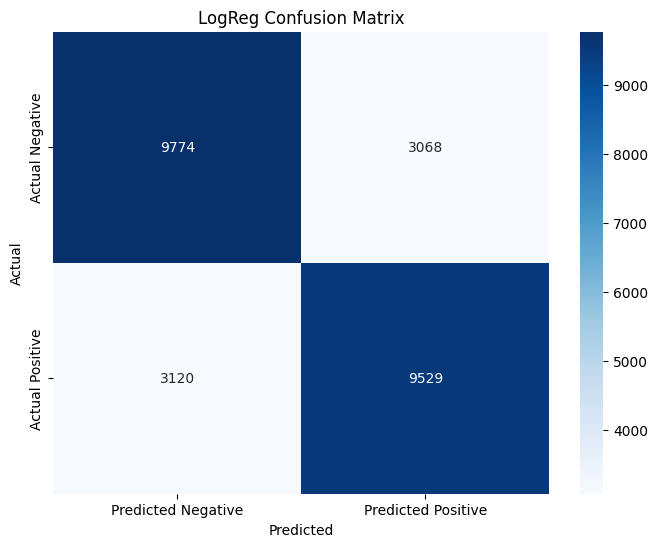

In [85]:
# Make predictions on the test set
y_pred = logreg.predict(X_test_scaled)
y_pred_probs = logreg.predict_proba(X_test_scaled)[:, 1]

brier = brier_score_loss(y_test, y_pred_probs)
print(f'Brier Score: {brier:.4f}')

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

logloss = log_loss(y_test, y_pred_probs)
print(f'Log Loss: {logloss:.4f}')

auc = roc_auc_score(y_test, y_pred_probs)
print(f'ROC-AUC Score: {auc:.4f}')

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LogReg Confusion Matrix')
plt.show()

### Outcome 
After analyzing the different solvers I identified that the defaul 'lbfgs' performed the best and worked well with the large feature set. It is also noted that setting C to 100 to implement a weaker regularization improved the model 

**Feature Importance** 

Features that were found to have minimal impact on the model include: 
  - **Conf_pac_10**: Conference rebranded to the Pac 12 with the addition of Colorado and Utah 
  - **Conf_gwc**: Great Western Conference became defunct in 2014
  - **Conf_mid_cont**: Mid Continental conference rebranded to the summit league in 2007

**Feature Correlation** 

Effective FG Percentage and FG Percentage were highly correlated, as expceted. This led me to remove Effective FG Percentage which helped increase the brier score for the model 



# K-Nearest Neighbors (k-NN)

k-NN Brier Score: 0.1822
k-NN Accuracy: 0.7230
k-NN Log Loss: 0.5482
k-NN ROC-AUC Score: 0.8009


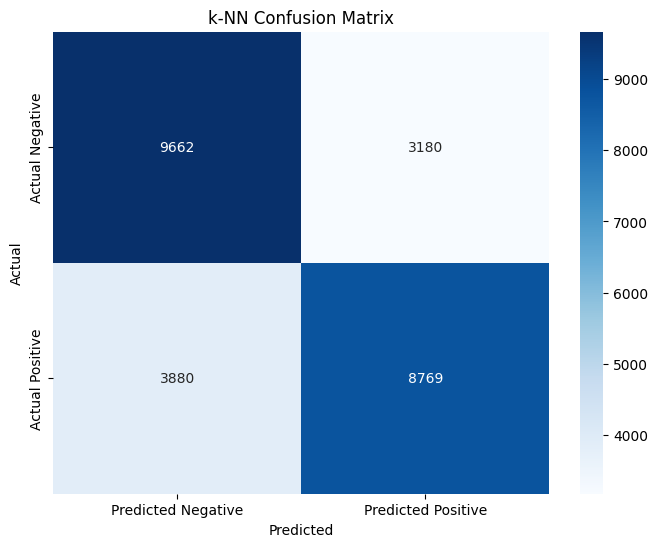

In [86]:
# k-NN model
knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_knn = knn.predict(X_test_scaled)
y_pred_probs_knn = knn.predict_proba(X_test_scaled)[:, 1]

# Calculate evaluation metrics
knn_brier = brier_score_loss(y_test, y_pred_probs_knn)
print(f'k-NN Brier Score: {knn_brier:.4f}')

knn_accuracy = accuracy_score(y_test, y_pred_knn)
print(f'k-NN Accuracy: {knn_accuracy:.4f}')

knn_logloss = log_loss(y_test, y_pred_probs_knn)
print(f'k-NN Log Loss: {knn_logloss:.4f}')

knn_auc = roc_auc_score(y_test, y_pred_probs_knn)
print(f'k-NN ROC-AUC Score: {knn_auc:.4f}')

# Calculate and display the confusion matrix
knn_conf_matrix = confusion_matrix(y_test, y_pred_knn)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(knn_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('k-NN Confusion Matrix')
plt.show()

# Decision Trees

## Boosting - Random Forest 

Random Forest Brier Score: 0.2171
Random Forest Accuracy: 0.6853
Random Forest Log Loss: 0.6638
Random Forest ROC-AUC Score: 0.7521


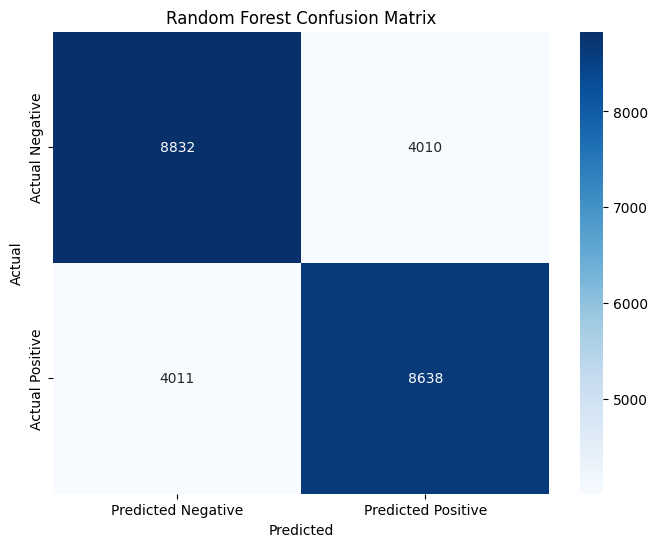

In [87]:
# Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf.predict(X_test)
y_pred_probs_rf = rf.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
rf_brier = brier_score_loss(y_test, y_pred_probs_rf)
print(f'Random Forest Brier Score: {rf_brier:.4f}')

rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {rf_accuracy:.4f}')

rf_logloss = log_loss(y_test, y_pred_probs_rf)
print(f'Random Forest Log Loss: {rf_logloss:.4f}')

rf_auc = roc_auc_score(y_test, y_pred_probs_rf)
print(f'Random Forest ROC-AUC Score: {rf_auc:.4f}')

# Calculate and display the confusion matrix
rf_conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()


## Bagging - Extreme Gradient Boosting

In [88]:
# Define the parameter grid
param_dist = {
    'n_estimators': np.arange(100, 1001, 100),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': np.arange(3, 10),
    'min_child_weight': np.arange(1, 10),
    'subsample': np.linspace(0.5, 1.0, 5),
    'colsample_bytree': np.linspace(0.5, 1.0, 5)
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss")

# Set up Randomized Search with Brier Score
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=20,  # Number of different parameter combinations to try
    scoring='neg_brier_score',  # Minimizing Brier Score
    cv=3,  # 3-fold cross-validation
    verbose=0,
    n_jobs=-1,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", random_search.best_params_)

# Best Brier Score (negated back to positive)
best_brier_score = -random_search.best_score_
print("Best Brier Score:", best_brier_score)

Best Parameters: {'subsample': np.float64(0.5), 'n_estimators': np.int64(500), 'min_child_weight': np.int64(1), 'max_depth': np.int64(7), 'learning_rate': np.float64(0.01), 'colsample_bytree': np.float64(0.75)}
Best Brier Score: 0.1648741947037575


XGBoost Brier Score: 0.1656
XGBoost Accuracy: 0.7524
XGBoost Log Loss: 0.4966
XGBoost ROC-AUC Score: 0.8354


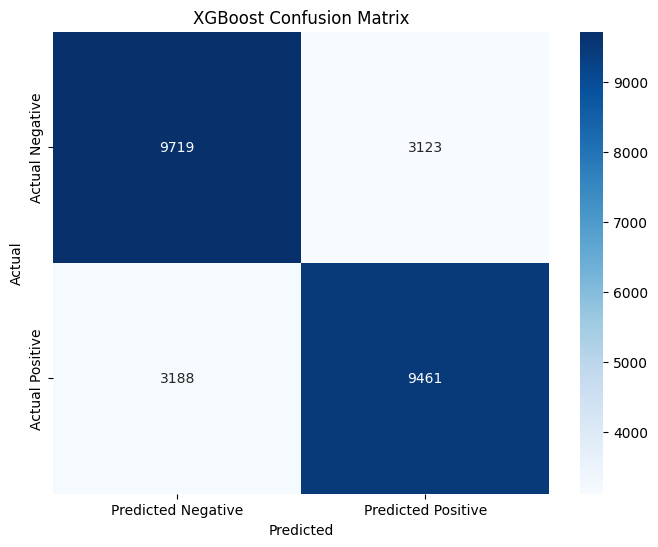

In [89]:
# Train the tuned XGBoost model
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic", eval_metric="logloss",
    subsample=0.5, n_estimators=500, min_child_weight=1, max_depth=7,
    learning_rate=0.01, colsample_bytree=0.75
)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)
y_pred_probs_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
xgb_brier = brier_score_loss(y_test, y_pred_probs_xgb)
print(f'XGBoost Brier Score: {xgb_brier:.4f}')

xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print(f'XGBoost Accuracy: {xgb_accuracy:.4f}')

xgb_logloss = log_loss(y_test, y_pred_probs_xgb)
print(f'XGBoost Log Loss: {xgb_logloss:.4f}')

xgb_auc = roc_auc_score(y_test, y_pred_probs_xgb)
print(f'XGBoost ROC-AUC Score: {xgb_auc:.4f}')

# Calculate and display the confusion matrix
xgb_conf_matrix = confusion_matrix(y_test, y_pred_xgb)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(xgb_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')
plt.show()

# Neural Network

In [92]:
# Train the Neural Network Model 
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),  # Two hidden layers with 128 and 64 neurons
    activation='relu',             # Use ReLU activation for non-linearity
    solver='adam',                 # Adam optimizer
    alpha=0.01,                    # L2 regularization (to prevent overfitting)
    max_iter=2000,                  # Number of training iterations
    random_state=57
)

mlp.fit(X_train_scaled, y_train)

# Get predicted probabilities
y_pred_proba = mlp.predict_proba(X_test_scaled)[:, 1]

# Calculate Brier Score (since lower is better)
brier_score = brier_score_loss(y_test, y_pred_proba)
print("Brier Score (Neural Network):", brier_score)



Brier Score (Neural Network): 0.20042432527269918


/Users/alexreid/Desktop/Projects/March_ML_Mania_2025/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


# Final Predictions 

In [111]:
# Use the regular season model to create predictions on the post season 
final_ml = pd.read_csv('../data/modeling/mens_tourney_ml.csv')
w_final_ml = pd.read_csv('../data/modeling/womens_tourney_ml.csv')

original_features = X_train.columns 
post_season = final_ml[original_features]

postseason_predictions = xgb_model.predict_proba(post_season)[:, 1]
final_ml['reg_season_pred'] = postseason_predictions
final_ml.head(50) 




,Season,DayNum,Team1,Team2,Team1_Wins,Win_Percentage_1,Points_Per_Game_1,FG_Percentage_1,Threes_Per_Game_1,Three_Point_Percentage_1,Free_Throws_Per_Game_1,Free_Throw_Percentage_1,Offensive_Rebound_Rate_1,Defensive_Rebound_Rate_1,Turnovers_Per_Game_1,Opp_FG_Percentage_1,Opp_Three_Point_Percentage_1,Opp_Free_Throws_Per_Game_1,Opp_Turnovers_Per_Game_1,ConfAbbrev_1,Win_pct_last_10_games_1,SRS_1,SOS_1,Pace_1,FTr_1,3PAr_1,offensiveRating_1,defensiveRating_1,Win_Percentage_2,Points_Per_Game_2,FG_Percentage_2,Threes_Per_Game_2,Three_Point_Percentage_2,Free_Throws_Per_Game_2,Free_Throw_Percentage_2,Offensive_Rebound_Rate_2,Defensive_Rebound_Rate_2,Turnovers_Per_Game_2,Opp_FG_Percentage_2,Opp_Three_Point_Percentage_2,Opp_Free_Throws_Per_Game_2,Opp_Turnovers_Per_Game_2,ConfAbbrev_2,Win_pct_last_10_games_2,SRS_2,SOS_2,Pace_2,FTr_2,3PAr_2,offensiveRating_2,defensiveRating_2,Seed_1,Seed_2,reg_season_pred
0,2014,134,1107,1291,1,0.562500,66.031250,43.914373,13.468750,36.426914,21.718750,74.820144,32.387476,70.905764,12.625000,41.863140,35.247209,15.843750,11.968750,aec,0.7,-3.31,-5.22,63.1,0.420,0.261,110.7,110.2,0.500000,76.250000,44.068706,24.906250,35.633626,21.687500,74.063401,28.345070,66.855524,12.000000,49.312896,33.626374,20.312500,13.281250,nec,0.6,-6.32,-4.44,70.0,0.367,0.434,112.5,112.6,16,16,0.560459
1,2014,134,1301,1462,1,0.617647,70.794118,45.865434,14.764706,30.278884,20.852941,66.149506,34.790060,63.735343,10.411765,42.438765,31.951641,23.794118,11.529412,acc,0.5,9.02,7.44,64.9,0.370,0.255,111.1,110.9,0.636364,72.212121,47.130919,14.727273,35.390947,22.848485,68.832891,34.105653,71.216098,12.363636,42.714127,35.394127,21.696970,11.272727,big_east,0.5,11.84,8.14,65.7,0.416,0.270,111.6,110.9,12,12,0.410528
2,2014,135,1142,1411,1,0.366667,62.000000,40.371517,18.900000,33.509700,17.766667,68.667917,30.842912,66.953714,8.966667,43.837442,33.978495,21.466667,10.833333,big_west,0.5,-1.34,1.69,60.8,0.326,0.354,110.2,110.9,0.562500,75.062500,45.821326,17.593750,35.879218,26.812500,71.095571,33.456905,68.924640,13.218750,44.632768,35.528596,17.906250,10.843750,swac,0.9,-8.41,-10.07,68.2,0.491,0.325,111.9,112.3,16,16,0.688337
3,2014,135,1397,1234,1,0.625000,70.500000,44.249292,16.875000,32.962963,22.781250,70.781893,39.692586,72.423146,10.875000,41.238318,34.047109,17.687500,10.843750,sec,0.6,17.34,7.84,62.8,0.416,0.308,112.2,109.1,0.625000,82.000000,46.469367,16.562500,35.283019,27.593750,73.272933,38.107639,71.063479,11.375000,41.401274,31.954351,20.500000,13.468750,big_ten,0.3,18.58,7.43,69.8,0.453,0.275,113.3,110.1,11,11,0.476186
4,2014,136,1163,1386,1,0.764706,71.852941,44.835046,18.382353,38.720000,21.000000,76.050420,31.238616,66.563467,11.676471,38.733126,32.894737,20.088235,12.911765,aac,0.7,17.23,8.63,65.5,0.383,0.343,111.4,107.7,0.727273,71.272727,46.858790,19.363636,38.028169,22.818182,64.143426,29.488372,72.393661,12.333333,41.842105,33.742331,17.636364,10.151515,a_ten,0.8,9.05,5.08,66.0,0.436,0.369,111.4,110.2,7,10,0.741718
5,2014,136,1173,1326,1,0.696970,73.393939,46.615300,17.393939,37.804878,22.727273,68.133333,34.940855,71.454712,12.000000,43.916570,34.296029,22.575758,12.636364,a_ten,0.8,10.55,5.34,65.4,0.406,0.319,112.0,110.3,0.735294,69.794118,44.876712,17.794118,32.561983,22.970588,68.886044,30.035026,69.982847,11.176471,40.515351,29.411765,15.911765,14.382353,big_ten,0.6,17.84,8.12,65.0,0.423,0.329,111.0,108.0,11,6,0.350462
6,2014,136,1196,1107,1,0.941176,70.735294,46.209588,18.617647,36.808847,22.882353,66.066838,35.765766,70.833333,11.323529,39.896966,33.272727,16.764706,13.970588,sec,1.0,20.69,8.54,62.7,0.424,0.346,111.8,107.3,0.562500,66.031250,43.914373,13.468750,36.426914,21.718750,74.820144,32.387476,70.905764,12.625000,41.863140,35.247209,15.843750,11.968750,aec,0.7,-3.31,-5.22,63.1,0.420,0.261,110.7,110.2,1,16,0.978925
7,2014,136,1217,1153,1,0.862069,73.448276,46.797386,14.896552,38.888889,25.172414,72.602740,32.575758,71.104231,11.551724,41.047745,32.613391,19.000000,14.068966,ivy,0.9,10.79,-0.47,64.6,0.4

In [ ]:
# Use Regular Season Model to predict 2025 post season matchups 
mens_season_25_data = pd.read_csv("../data/modeling/mens_25_season_ml.csv")

mens_25_seeds = pd.read_csv("../data/MNCAATourneySeeds.csv")
mens_25_seeds['Seed'] = mens_25_seeds['Seed'].str[1:].str.rstrip('ab')

active_m_teams = mens_25_seeds[mens_25_seeds['Season'] == 2025]


print(f"Active men's teams: {len(active_m_teams)}")

matchups_list = [] 

# Ensure matchups are only between active teams
for team1, team2 in combinations(active_m_teams['TeamID'], 2):
    lower_id = min(team1, team2)
    higher_id = max(team1, team2)
    seed1 = active_m_teams.loc[active_m_teams['TeamID'] == lower_id, 'Seed'].values[0]
    seed2 = active_m_teams.loc[active_m_teams['TeamID'] == higher_id, 'Seed'].values[0]
    matchups_list.append(
        {
            'Team1': lower_id, 
            'Team2': higher_id,
            'Seed_1': seed1, 
            'Seed_2': seed2 
        }
    )

m_matchups = pd.DataFrame(matchups_list)


# Merge games dataset with teams stats 
tourney_2025 = m_matchups.merge(mens_season_25_data, left_on=['Team1'], right_on=['TeamID'], how='left')
tourney_2025 = tourney_2025.rename(columns={col: col + "_1" for col in mens_season_25_data.columns if col not in ["Season", "TeamID"]})

tourney_2025 = tourney_2025.merge(mens_season_25_data, left_on=['Team2'], right_on=['TeamID'], how='left')
tourney_2025 = tourney_2025.rename(columns={col: col + "_2" for col in mens_season_25_data.columns if col not in ["Season", "TeamID"]})
tourney_2025.drop(columns=['TeamID_x','TeamID_y', 'Season_x', 'Season_y'], inplace=True)

# Use the regular season model to create predictions on the post season 

original_features = X_train.columns 
postseason_25 = tourney_2025[original_features]

postseason_25_predictions = xgb_model.predict_proba(postseason_25)[:, 1]
tourney_2025['reg_season_pred'] = postseason_25_predictions
tourney_2025['reg_season_pred'] = tourney_2025['reg_season_pred'].round(3)

tourney_2025

Active men's teams: 68


,Team1,Team2,Seed_1,Seed_2,Win_Percentage_1,Points_Per_Game_1,FG_Percentage_1,Threes_Per_Game_1,Three_Point_Percentage_1,Free_Throws_Per_Game_1,Free_Throw_Percentage_1,Offensive_Rebound_Rate_1,Defensive_Rebound_Rate_1,Turnovers_Per_Game_1,Opp_FG_Percentage_1,Opp_Three_Point_Percentage_1,Opp_Free_Throws_Per_Game_1,Opp_Turnovers_Per_Game_1,ConfAbbrev_1,Win_pct_last_10_games_1,SRS_1,SOS_1,Pace_1,FTr_1,3PAr_1,offensiveRating_1,defensiveRating_1,Win_Percentage_2,Points_Per_Game_2,FG_Percentage_2,Threes_Per_Game_2,Three_Point_Percentage_2,Free_Throws_Per_Game_2,Free_Throw_Percentage_2,Offensive_Rebound_Rate_2,Defensive_Rebound_Rate_2,Turnovers_Per_Game_2,Opp_FG_Percentage_2,Opp_Three_Point_Percentage_2,Opp_Free_Throws_Per_Game_2,Opp_Turnovers_Per_Game_2,ConfAbbrev_2,Win_pct_last_10_games_2,SRS_2,SOS_2,Pace_2,FTr_2,3PAr_2,offensiveRating_2,defensiveRating_2,reg_season_pred
0,1104,1181,02,01,0.757576,91.121212,48.259643,29.787879,34.994914,25.848485,71.629543,32.700994,73.296789,12.121212,42.456609,30.798479,23.060606,10.060606,sec,0.5,25.97,16.27,76.2,0.401,0.462,126.2,96.8,0.911765,82.705882,48.805970,26.823529,37.719298,18.970588,78.449612,34.072581,77.030568,9.205882,38.645621,30.872483,14.676471,10.764706,acc,1.0,30.32,9.52,66.6,0.321,0.454,128.8,90.1,0.344
1,1181,1458,01,03,0.911765,82.705882,48.805970,26.823529,37.719298,18.970588,78.449612,34.072581,77.030568,9.205882,38.645621,30.872483,14.676471,10.764706,acc,1.0,30.32,9.52,66.6,0.321,0.454,128.8,90.1,0.742857,79.714286,45.181598,28.400000,34.909457,19.914286,82.783357,24.836601,75.125628,9.314286,41.431262,33.012048,17.028571,9.685714,big_ten,0.6,21.15,11.41,68.7,0.340,0.478,121.9,98.2,0.732
2,1112,1181,04,01,0.647059,81.735294,47.266570,21.058824,32.402235,22.235294,78.439153,34.559535,74.319728,11.264706,41.522989,33.600000,17.911765,11.088235,big_twelve,0.5,23.14,13.84,70.2,0.366,0.346,122.8,96.7,0.911765,82.705882,48.805970,26.823529,37.719298,18.970588,78.449612,34.072581,77.030568,9.205882,38.645621,30.872483,14.676471,10.764706,acc,1.0,30.32,9.52,66.6,0.321,0.454,128.8,90.1,0.162
3,1181,1332,01,05,0.911765,82.705882,48.805970,26.823529,37.719298,18.970588,78.449612,34.072581,77.030568,9.205882,38.645621,30.872483,14.676471,10.764706,acc,1.0,30.32,9.52,66.6,0.321,0.454,128.8,90.1,0.727273,76.212121,45.684755,22.636364,34.002677,19.575758,76.315789,27.579162,71.854613,10.515152,43.138244,31.713900,16.636364,11.575758,big_ten,0.8,17.50,12.23,68.6,0.334,0.386,116.4,97.1,0.737
4,1140,1181,06,01,0.727273,80.969697,48.223350,28.848485,37.079832,18.000000,70.538721,31.606218,76.267943,11.454545,42.879499,34.782609,17.121212,11.363636,big_twelve,0.9,19.82,9.72,67.8,0.302,0.483,121.6,100.4,0.911765,82.705882,48.805970,26.823529,37.719298,18.970588,78.449612,34.072581,77.030568,9.205882,38.645621,30.872483,14.676471,10.764706,acc,1.0,30.32,9.52,66.6,0.321,0.454,128.8,90.1,0.194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,1213,1303,13,15,0.781250,78.500000,45.922747,19.562500,31.629393,25.593750,73.504274,30.715005,73.724008,12.625000,41.486558,32.055215,19.062500,14.406250,wac,0.9,5.82,-3.02,72.7,0.442,0.339,109.0,101.5,0.625000,77.750000,46.401719,22.468750,36.717663,21.156250,73.264402,27.783453,78.118609,10.437500,45.285088,35.098522,21.468750,9.781250,summit,0.8,-1.07,-2.85,69.2,0.366,0.390,110.6,110.5,0.773
2274,1213,1313,13,16,0.781250,78.500000,45.922747,19.562500,31.629393,25.593750,73.504274,30.715005,73.724008,12.625000,41.486558,32.055215,19.062500,14.406250,wac,0.9,5.82,-3.02,72.7,0.442,0.339,109.0,101.5,0.677419,74.903226,48.064702,15.483871,31.250000,21.774194,75.259259,29.513889,67.301906,11.709677,42.494357,33.949802,19.935484,12.096774,meac,0.8,-3.61,-7.48,68.2,0.388,0.288,108.9,106.8,0.794
2275,1303,1423,15,14,0.625000,77.750000,46.401719,22.468750,36.717663,21.156250,73.264402,27.783453,78.118

In [ ]:
# Use Regular Season Model to predict 2025 post season matchups 
womens_season_25_data = pd.read_csv("../data/preprocessing/womens_summary_season_data.csv")
womens_season_25_data = womens_season_25_data[womens_season_25_data['Season'] == 2025]

womens_25_seeds = pd.read_csv("../data/WNCAATourneySeeds.csv")
womens_25_seeds['Seed'] = womens_25_seeds['Seed'].str[1:].str.rstrip('ab')
active_w_teams = womens_25_seeds[womens_25_seeds['Season'] == 2025]


print(f"Active women's teams: {len(active_w_teams)}")

matchups_list = [] 

# Ensure matchups are only between active teams
for team1, team2 in combinations(active_w_teams['TeamID'], 2):
    lower_id = min(team1, team2)
    higher_id = max(team1, team2)
    seed1 = active_w_teams.loc[active_w_teams['TeamID'] == lower_id, 'Seed'].values[0]
    seed2 = active_w_teams.loc[active_w_teams['TeamID'] == higher_id, 'Seed'].values[0]
    matchups_list.append(
        {
            'Team1': lower_id, 
            'Team2': higher_id,
            'Seed_1': seed1, 
            'Seed_2': seed2 
        }
    )

w_matchups = pd.DataFrame(matchups_list)

# Merge games dataset with teams stats 
tourney_2025 = w_matchups.merge(womens_season_25_data, left_on=['Team1'], right_on=['TeamID'], how='left')
tourney_2025 = tourney_2025.rename(columns={col: col + "_1" for col in womens_season_25_data.columns if col not in ["Season", "TeamID"]})

tourney_2025 = tourney_2025.merge(womens_season_25_data, left_on=['Team2'], right_on=['TeamID'], how='left')
tourney_2025 = tourney_2025.rename(columns={col: col + "_2" for col in womens_season_25_data.columns if col not in ["Season", "TeamID"]})
tourney_2025.drop(columns=['TeamID_x', 'TeamID_y', 'Season_x', 'Season_y'], inplace=True)

# Use the regular season model to create predictions on the post season 

original_features = X_train.columns 
postseason_25 = tourney_2025[original_features]

postseason_25_predictions = xgb_model.predict_proba(postseason_25)[:, 1]
tourney_2025['reg_season_pred'] = postseason_25_predictions
tourney_2025['reg_season_pred'] = tourney_2025['reg_season_pred'].round(3)

In [116]:
# 2025 Tourney Prediction Data 
output_dir = Path("..") / "data" / "modeling"
output_dir.mkdir(parents=True, exist_ok =True)
m_25_final_output_path = output_dir / "mens_25_final_ml.csv"
#w_25_final_output_path = output_dir / "womens_25_final_ml.csv"
final_ml.to_csv(m_25_final_output_path, index=False)

In [117]:
# 2025 Post Season Training Data 
output_dir = Path("..") / "data" / "modeling"
output_dir.mkdir(parents=True, exist_ok =True)
m_final_output_path = output_dir / "mens_final_ml.csv"
#w_final_output_path = output_dir / "womens_final_ml.csv"
final_ml.to_csv(m_final_output_path, index=False)